In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and Prepare the MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
full_train_data = MNIST(root='data', train=True, download=True, transform=transform)
test_data = MNIST(root='data', train=False, download=True, transform=transform)

# Split full training data into training and validation
train_size = int(0.8 * len(full_train_data))
valid_size = len(full_train_data) - train_size
train_data, valid_data = random_split(full_train_data, [train_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)







100%|██████████| 9912422/9912422 [00:00<00:00, 70307982.16it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68399601.26it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33380270.76it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20053188.18it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Step 2: Define the Deep Neural Network Model
class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        # self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.dropout(F.relu(self.fc1(x)))
        # x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# Initialize the network
model = DeepNN()

# Step 3: Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
if train_on_gpu:
  model.cuda()

In [ ]:
# Step 4: Train the Model
def train_model(num_epochs):
    train_losses = []  # List to store training losses
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for images, labels in train_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        # Validation
        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        # Append the losses to the lists
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        # Print training and validation losses
        print(f'Epoch {epoch+1}/{num_epochs} \t Training Loss: {train_loss:.4f} \t Validation Loss: {valid_loss:.4f}')
    # Plot the training and validation losses
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, 1)  # Set y-axis limits
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.show()

# Step 5: Validate the Model (Included in Training Function)

# Step 6: Test the Model
def test_model():
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = (correct / total) * 100
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Run the training and testing
num_epochs = 50
valid_losses=train_model(num_epochs)
test_model()


Epoch 1/50 	 Training Loss: 0.4932 	 Validation Loss: 0.1925
Epoch 2/50 	 Training Loss: 0.2341 	 Validation Loss: 0.1670
Epoch 3/50 	 Training Loss: 0.1876 	 Validation Loss: 0.1301
Epoch 4/50 	 Training Loss: 0.1612 	 Validation Loss: 0.1190
Epoch 5/50 	 Training Loss: 0.1441 	 Validation Loss: 0.1133


KeyboardInterrupt: 

In [ ]:
import copy
import torch.nn as nn
import torch.nn.functional as F

def newlayer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    if isinstance(layer, torch.nn.MaxPool2d):
      return layer
    else:
      layer.weight = torch.nn.Parameter(g(layer.weight))
      layer.bias = torch.nn.Parameter(g(layer.bias))
      return layer

In [ ]:
class LRPDropout(nn.Module):
    def __init__(self,dropoutrate=0.5):
        super(LRPDropout, self).__init__()
        self.mask = None
        self.rate=dropoutrate

    def forward(self, x):
        if self.training:
            if self.mask is None:
              return x
            # During training, apply dropout
            # print(self.mask.shape,x.shape)
            output = (x * self.mask )/ (1 - self.rate)
        else:
            # During evaluation, don't apply dropout
            output = x
        return output



    def update_mask(self, lrp_values, percentile=50):
        percentile=100 - self.rate*100
        # calculate the threshold based on LRP values
        threshold = np.percentile((torch.abs(lrp_values).cpu().numpy()), percentile)

        # create a binary mask based on the threshold
        self.mask = (torch.abs(lrp_values) < threshold).float().to("cuda")
        # print(self.mask)

    def show_mask(self):
        print(self.mask)

In [ ]:
# Step 2: Define the Deep Neural Network Model
class DeepNN_LRP(nn.Module):
    def __init__(self):
        super(DeepNN_LRP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.dropout1= LRPDropout(0.1)
        # self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(512, 128)
        self.dropout2= LRPDropout(0.1)
        self.fc4 = nn.Linear(128, 64)
        self.dropout3= LRPDropout(0.1)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.dropout1(F.relu(self.fc1(x)))
        # x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout2(F.relu(self.fc3(x)))
        x = self.dropout3(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# Initialize the network
modellrp = DeepNN_LRP()

# Step 3: Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modellrp.parameters(), lr=0.001)

if train_on_gpu:
  modellrp.cuda()

In [ ]:
def LRP_individual(model, X, target, device):
    model.eval()
    # Get the list of layers of the network
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)][1:]
    # print(layers)
    # Propagate the input
    L = len(layers)
    A = [X] + [X] * L # Create a list to store the activation produced by each layer
    # print(layers)
    # print(len(A),layers)
    for layer in range(L):
        # print(A[layer].shape,layers[layer])
        # print(layers[layer])
        # if isinstance(layers[layer],torch.nn.Linear):
        #   # print(layers[layer])
        #   A[layer]=A[layer].reshape(-1,1,layers[layer].in_features)
        # print(A[layer].shape,layers[layer])
        if isinstance(layers[layer], LRPDropout):
          # print(A[layer].shape)
          A[layer + 1] =A[layer]
        else:
          A[layer + 1] = layers[layer].forward(A[layer])

    # Get the relevance of the last layer using the highest classification score of the top layer
    T = A[-1].to(device)  # Remove .numpy().tolist()
    index = target
    # print(T.shape)
    T = torch.abs(T) * 0
    # print(T)
    T[-1, index] = 1  # Modify to index the element directly
    T = T.to(device)
    # Create the list of relevances with (L + 1) elements and assign the value of the last one
    R = [None] * L + [(A[-1] * T).data + 1e-6]
    # print("hi")
     # Propagation procedure from the top-layer towards the lower layers
    for layer in range(0, L)[::-1]:

        if isinstance(layers[layer], torch.nn.Conv2d) or isinstance(layers[layer], torch.nn.Conv3d) \
                or isinstance(layers[layer],torch.nn.Linear) or isinstance(layers[layer],torch.nn.MaxPool2d) :


            rho = lambda p: p

            A[layer] = A[layer].data.requires_grad_(True).to(device)

            # Step 1: Transform the weights of the layer and executes a forward pass
            z = newlayer(layers[layer], rho)

            z=z.forward(A[layer]) + 1e-9
            # print(layers[layer],z.shape,A[layer].shape)
            # print(z.shape,R[layer+1].shape,layers[layer],A[layer].shape)
            # Step 2: Element-wise division between the relevance of the next layer and the denominator
            # print(R[layer+1].shape, z.shape,layer+1)
            s = (R[layer+1] / z).data
            # print(s)
            # Step 3: Calculate the gradient and multiply it by the activation layer
            (z * s).sum().backward()
            c = A[layer].grad
            R[layer] = (A[layer] * c).cuda().data
            # R[layer] = R[layer + 1]
            # print(R)

        else:
            # print(layers[layer],"else")
            R[layer] = R[layer + 1]
        # if layer == 10:
        #             # print("hi")
        #             R[layer] = R[layer].reshape(-1,512,4,4)
    # Return the relevance of the all the layers
    model.train()
    return R


Epoch 1/100 	 Training Loss: 0.4442 	 Validation Loss: 0.2387
Epoch 2/100 	 Training Loss: 0.2034 	 Validation Loss: 0.1615
Epoch 3/100 	 Training Loss: 0.1530 	 Validation Loss: 0.1227
Epoch 4/100 	 Training Loss: 0.1227 	 Validation Loss: 0.1213
Epoch 5/100 	 Training Loss: 0.1045 	 Validation Loss: 0.1089
Epoch 6/100 	 Training Loss: 0.0906 	 Validation Loss: 0.1008
Epoch 7/100 	 Training Loss: 0.0882 	 Validation Loss: 0.1244
Epoch 8/100 	 Training Loss: 0.0807 	 Validation Loss: 0.1039
Epoch 9/100 	 Training Loss: 0.0759 	 Validation Loss: 0.0928
Epoch 10/100 	 Training Loss: 0.0684 	 Validation Loss: 0.0994
Epoch 11/100 	 Training Loss: 0.0630 	 Validation Loss: 0.0741
Epoch 12/100 	 Training Loss: 0.0614 	 Validation Loss: 0.0820
Epoch 13/100 	 Training Loss: 0.0604 	 Validation Loss: 0.0822
Epoch 14/100 	 Training Loss: 0.0541 	 Validation Loss: 0.0779
Epoch 15/100 	 Training Loss: 0.0523 	 Validation Loss: 0.0822
Epoch 16/100 	 Training Loss: 0.0511 	 Validation Loss: 0.0807
E

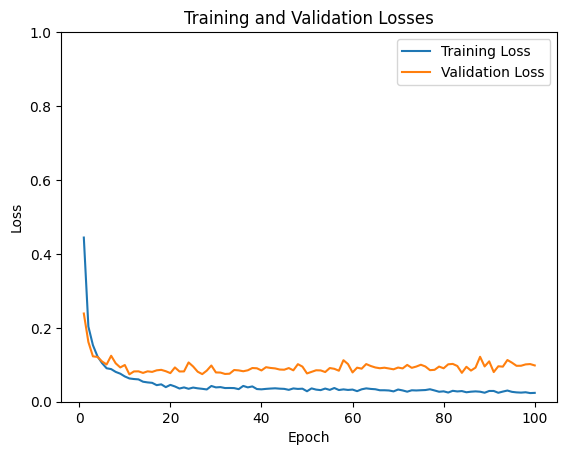

In [ ]:

# Step 4: Train the Model
def train_modellrp(num_epochs,model):
    train_losses = []  # List to store training losses
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for images, labels in train_loader:
            # print(images.size())
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            Rel = LRP_individual(modellrp, images.reshape(-1,28*28).float().to("cuda"),labels,device="cuda")
            # [print(tensor.shape,end="...") for tensor in Rel]
            # print()
            avg_tensor=torch.tensor([])
            for i in range(len(Rel)):
                if(len(avg_tensor)==0):
                    avg_tensor=Rel
                    for j in range(len(Rel)):
                        avg_tensor[j] = torch.mean(Rel[j], dim=0)
            avg_tensor[i] = torch.mean(Rel[i], dim=0)
            # [print(tensor.shape,end="...") for tensor in avg_tensor]
            modellrp.dropout1.update_mask(avg_tensor[1])
            modellrp.dropout2.update_mask(avg_tensor[3])
            # # print("Hi")
            modellrp.dropout3.update_mask(avg_tensor[5])
            # Validation
        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)

        # Calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        # Append the losses to the lists
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        # Print training and validation losses
        print(f'Epoch {epoch+1}/{num_epochs} \t Training Loss: {train_loss:.4f} \t Validation Loss: {valid_loss:.4f}')
    # Plot the training and validation losses
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, 1)  # Set y-axis limits
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.show()


# Run the training and testing
num_epochs = 100
train_modellrp(num_epochs,modellrp)
# test_model()


In [ ]:
def test_model(model):
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = (correct / total) * 100
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
test_model(modellrp)

Test Loss: 0.0944, Test Accuracy: 97.50%
